<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# A2: Data Exploration

This notebook loads the available datasets and illustrates selected aspects of data properties.

---

<span style="color:gray">
Version 0.3.7 (August 2, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf


%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [2]:
path = '../data'
categories = ['consumption', 'weather', 'profiles']
files = [path + '/' + '20201015_' + name + '.xlsx' for name in categories]
timezone = 'Europe/Madrid'

selected_customers =  [5, 228, 298, 119, 90, 286, 293, 191, 114, 301]

### Function Definitions

In [3]:
def to_UTC(data, tz=timezone):
    try:
        data.index = data.index.tz_localize(tz=tz, ambiguous='infer').tz_convert(tz='UTC')
    except:
        pass
    return

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

### Loading Data

In [4]:
consumptions = pd.read_excel(files[categories.index('consumption')], parse_dates=[0], index_col=0)
consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
consumptions.index.name = 'time'
to_UTC(consumptions)
crop(consumptions)

In [5]:
weather = pd.read_excel(files[categories.index('weather')], parse_dates=[0], index_col=0)
weather.columns = consumptions.columns
weather.index.name = 'time'
to_UTC(weather)
crop(weather)

In [6]:
customers = pd.read_excel(files[categories.index('profiles')])
customers.columns = ['customer', 'profile']

In [7]:
profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])

In [8]:
weather_forecast = weather.copy()
weather_forecast.index = weather_forecast.index + pd.Timedelta(days=1)

In [9]:
holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")

In [10]:
days = pd.DataFrame(pd.to_datetime(consumptions.index.date), index=consumptions.index, columns=['date'])
days['day_of_week'] = list(days.index.dayofweek)
days['day_of_month'] = list(days.index.day)
days['month'] = list(days.index.month)
days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
days = days.groupby(['date']).first()

In [11]:
consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), index=days.index)

In [12]:
weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)

In [13]:
households = customers[customers['profile'].astype(str).str.contains('hogares')].index.values

### Daily Mean Energy Consumption for 10 Selected Customers

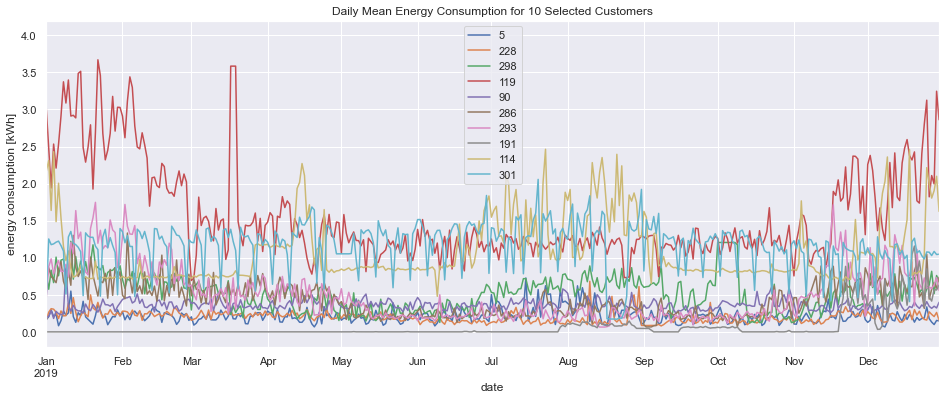

In [14]:
_ = consumptions_daily_mean.loc[:,selected_customers].plot(ylabel='energy consumption [kWh]',
                        title='Daily Mean Energy Consumption for 10 Selected Customers',
                                                          ylim=(-0.2,4.2))

### Aggregated Daily Mean Energy Consumptions of all Household Customers

In [15]:
consumptions_daily_mean_housholds = consumptions_daily_mean.loc[:,households]

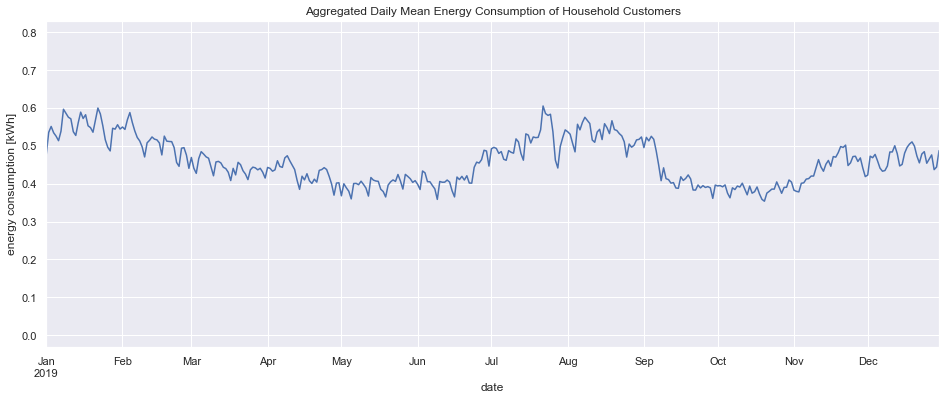

In [16]:
_ = consumptions_daily_mean_housholds.mean(axis=1).plot(ylabel='energy consumption [kWh]',
                        title='Aggregated Daily Mean Energy Consumption of Household Customers',
                                                               ylim=(-0.03,0.83))

### Histograms of Hourly Consumptions of Household Customers

In [17]:
consumptions_housholds = consumptions.loc[:,households]

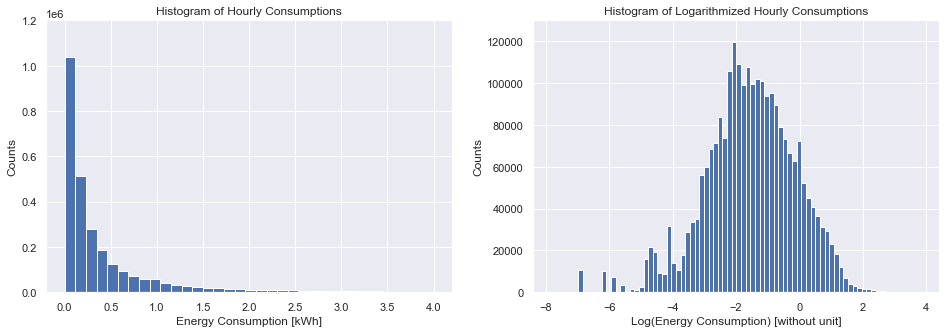

In [19]:
plt.figure(figsize=(16,5))
ax1=plt.subplot(121, title="Histogram of Hourly Consumptions")
ax1.hist((consumptions_housholds.to_numpy().reshape(-1, 1)).flatten(), bins=200)
ax1.set_xlim(-0.2,4.2)
ax1.set_ylim(0,1.2e6)
ax1.set_xlabel("Energy Consumption [kWh]")
ax1.set_ylabel("Counts")
ax2=plt.subplot(122, title="Histogram of Logarithmized Hourly Consumptions")
ax2.hist(np.log(np.float64((consumptions_housholds.to_numpy().reshape(-1, 1)).flatten())+1e-5), bins=100)
ax2.set_xlim(-8.4,4.4)
ax2.set_ylim(0,130000)
ax2.set_ylabel("Counts")
ax2.set_xlabel("Log(Energy Consumption) [without unit]")
#plt.tight_layout()
plt.show() 